In [154]:
import pandas as pd
from glob import glob
import ahocorasick
import pyarrow.parquet as pq
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyopenms import *
import os
from multiprocessing import Manager
from pandarallel import pandarallel
from Bio import pairwise2,SeqIO
import warnings
warnings.filterwarnings('ignore')

In [155]:
def get_all_number_from_parquet(parquet_file1, parquet_file2):
    if parquet_file2:
        table1 = pq.read_table(parquet_file1, columns=["sequence"])
        parquet1 = table1.to_pandas()

        table2 = pq.read_table(parquet_file2, columns=["sequence"])
        parquet2 = table2.to_pandas()

        from_parquet = pd.concat([parquet1, parquet2], axis=0, ignore_index=True)
    else:
        table = pq.read_table(parquet_file1, columns=["sequence"])
        from_parquet = table.to_pandas()
    return[len(from_parquet) , from_parquet["sequence"].nunique()]
        
def get_gca_usi_number(file):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    return df['usi'].nunique()

def get_gca_seq_number(file):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    return df['sequence'].nunique()

def get_gca_seq_set(file):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    return set(df['sequence'])
    
def get_gca_usi_number_from_spectrumai(file):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    df = df[(df['position'] == 'non-canonical') | (df['flanking_ions_support'] == 'YES')]
    return df['usi'].nunique()

def get_SNR_number(file, lower_threshold, upper_threshold):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    df = df[df['pearsonr_Y'] > 0.1]
    df = df[df['signal_to_noise'] > lower_threshold]
    df = df[df['signal_to_noise'] < upper_threshold]
    return len(df)

def save_final_usis(file1,file2,save_path):
    df1 = pd.read_table(file1, sep = "," ,compression="gzip", usecols = ["sequence","usi"])
    df2 = pd.read_table(file2, sep = "," ,compression="gzip", usecols = ["sequence","usi"])

    df = pd.concat([df1,df2],axis = 0)
    df = df.drop_duplicates()
    df.to_csv(save_path, header=1, sep="\t", index = None)

In [156]:
save_final_usis("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz",
                "PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz",
                "count-tables/all_pep_usis.tsv")

In [157]:
get_SNR_number("PXD010154/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip.csv.gz", 3.52, 15.27)

109733

In [158]:
get_SNR_number("PXD016999/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip.csv.gz", 7.2, 23.01)

34893

### PXD010154

In [159]:
all_number_from_parquet1 = get_all_number_from_parquet("PXD010154/sdrf_parquet/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet", False)
print("Number of all PSM from parquet: {}".format(all_number_from_parquet1[0]))
print("Number of all peptide sequence from parquet: {}".format(all_number_from_parquet1[1]))

all_gca_number1 = get_gca_usi_number("PXD010154/to-ms2pip-snr-tables/gca_peptides_for_deeplc.csv.gz")
print("Number of all-gca-PSM: {}".format(all_gca_number1))

ms2pip_SNR_gca_number1 = get_SNR_number("PXD010154/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip.csv.gz", 3.52, 15.27)
print("Number of ms2pip-SNR-gca-PSM: {}".format(ms2pip_SNR_gca_number1))

ms2pip_gca_number1 = get_gca_usi_number("PXD010154/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip_filtered.csv.gz")
print("Number of ms2pip-gca-PSM: {}".format(ms2pip_gca_number1))

ms2pip_spectrumai_gca_number1 = get_gca_usi_number_from_spectrumai("PXD010154/to-spectrumai-tables/gca_peptides_for_deeplc_ms2pip_spectrumai_filtered.csv.gz")
print("Number of ms2pip-spectrumai-gca-PSM: {}".format(ms2pip_spectrumai_gca_number1))

ms2pip_spectrumai_deeplc_gca_number1 = get_gca_usi_number("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz")
print("Number of ms2pip-spectrumai-deeplc-gca-PSM: {}".format(ms2pip_spectrumai_deeplc_gca_number1))

ms2pip_spectrumai_deeplc_gca_seq_number1 = get_gca_seq_number("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz")
print("Number of ms2pip-spectrumai-deeplc-gca-peptide-Seq: {}".format(ms2pip_spectrumai_deeplc_gca_seq_number1))

Number of all PSM from parquet: 16294599
Number of all peptide sequence from parquet: 508840
Number of all-gca-PSM: 128910
Number of ms2pip-SNR-gca-PSM: 109733
Number of ms2pip-gca-PSM: 102125
Number of ms2pip-spectrumai-gca-PSM: 61345
Number of ms2pip-spectrumai-deeplc-gca-PSM: 58218
Number of ms2pip-spectrumai-deeplc-gca-peptide-Seq: 3989


### PXD016999

In [160]:
all_number_from_parquet2 = get_all_number_from_parquet("PXD016999/sdrf_parquet/PXD016999-first-instrument-8b005cd8-d641-4d1e-a085-c92ed045b4da.psm.parquet",
                                                       "PXD016999/sdrf_parquet/PXD016999-second-instrument-2739df94-8ceb-4033-a8d3-91adba121f3f.psm.parquet")
print("Number of all PSM from parquet: {}".format(all_number_from_parquet2[0]))
print("Number of all peptide sequence from parquet: {}".format(all_number_from_parquet2[1]))

all_gca_number2 = get_gca_usi_number("PXD016999/to-ms2pip-snr-tables/gca_peptides_for_deeplc.csv.gz")
print("Number of all-gca-PSM: {}".format(all_gca_number2))

ms2pip_SNR_gca_number2 = get_SNR_number("PXD016999/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip.csv.gz", 7.2, 23.01)
print("Number of ms2pip-SNR-gca-PSM: {}".format(ms2pip_SNR_gca_number2))

ms2pip_gca_number2 = get_gca_usi_number("PXD016999/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip_filtered.csv.gz")
print("Number of ms2pip-gca-PSM: {}".format(ms2pip_gca_number2))

ms2pip_spectrumai_gca_number2 = get_gca_usi_number_from_spectrumai("PXD016999/to-spectrumai-tables/gca_peptides_for_deeplc_ms2pip_spectrumai_filtered.csv.gz")
print("Number of ms2pip-spectrumai-gca-PSM: {}".format(ms2pip_spectrumai_gca_number2))

ms2pip_spectrumai_deeplc_gca_number2 = get_gca_usi_number("PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz")
print("Number of ms2pip-spectrumai-deeplc-gca-PSM: {}".format(ms2pip_spectrumai_deeplc_gca_number2))

ms2pip_spectrumai_deeplc_gca_seq_number2 = get_gca_seq_number("PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz")
print("Number of ms2pip-spectrumai-deeplc-gca-peptide-Seq: {}".format(ms2pip_spectrumai_deeplc_gca_seq_number2))

Number of all PSM from parquet: 7239144
Number of all peptide sequence from parquet: 285330
Number of all-gca-PSM: 41232
Number of ms2pip-SNR-gca-PSM: 34893
Number of ms2pip-gca-PSM: 32725
Number of ms2pip-spectrumai-gca-PSM: 26629
Number of ms2pip-spectrumai-deeplc-gca-PSM: 25378
Number of ms2pip-spectrumai-deeplc-gca-peptide-Seq: 1955


### Combine

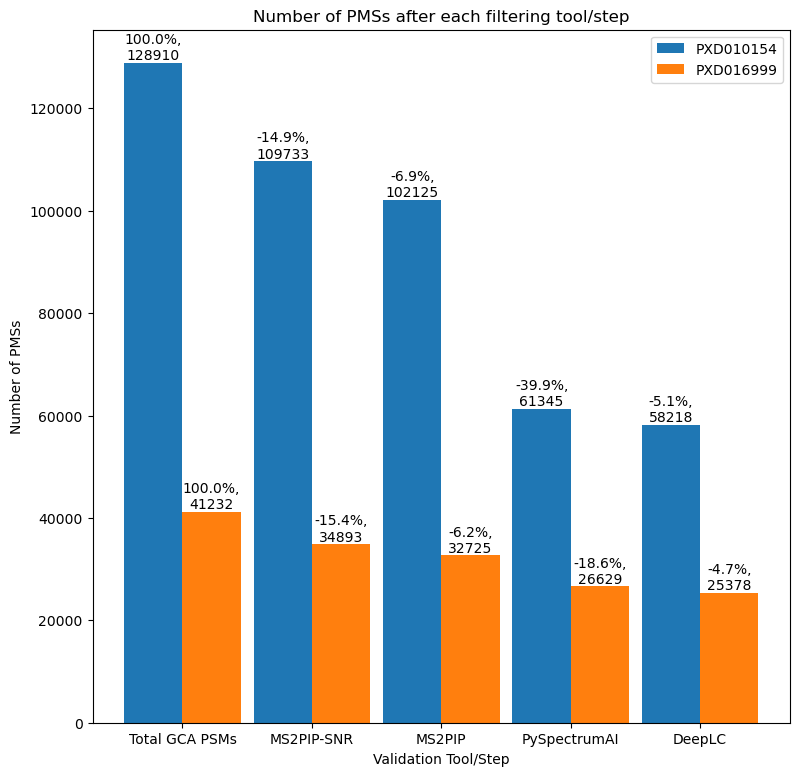

In [161]:
labels = ['Total GCA PSMs','MS2PIP-SNR', 'MS2PIP', 'PySpectrumAI', 'DeepLC']
values1 = [all_gca_number1, ms2pip_SNR_gca_number1 ,ms2pip_gca_number1, ms2pip_spectrumai_gca_number1, ms2pip_spectrumai_deeplc_gca_number1]
values2 = [all_gca_number2, ms2pip_SNR_gca_number2 ,ms2pip_gca_number2, ms2pip_spectrumai_gca_number2, ms2pip_spectrumai_deeplc_gca_number2]

x = np.arange(len(labels)) 
plt.figure(figsize=(9,9))
bar_width = 0.45
bars1 = plt.bar(x - bar_width/2, values1, width=bar_width, align='center', label='PXD010154')
bars2 = plt.bar(x + bar_width/2, values2, width=bar_width, align='center', label='PXD016999')

plt.title('Number of PMSs after each filtering tool/step')
plt.xlabel('Validation Tool/Step')
plt.ylabel('Number of PMSs')
plt.xticks(x, labels)
plt.legend()
for i,bar in enumerate(bars1):
    num = bar.get_height()
    if i == 0:
        s = "{},\n{}".format("{:.1%}".format(1),num)
        pre = num
    else:
        percentile = (pre - num)/pre 
        s = "-{},\n{}".format("{:.1%}".format(percentile),num)
        pre = num
    plt.text(bar.get_x() + bar.get_width()/2, num, s, ha='center', va='bottom')
for i,bar in enumerate(bars2):
    num = bar.get_height()
    if i == 0:
        s = "{},\n{}".format("{:.1%}".format(1),num)
        pre = num
    else:
        percentile = (pre - num)/pre 
        s = "-{},\n{}".format("{:.1%}".format(percentile),num)
        pre = num       
    plt.text(bar.get_x() + bar.get_width()/2, num, s, ha='center', va='bottom')
plt.savefig('count-plots/filter_count-plot.svg', format='svg')

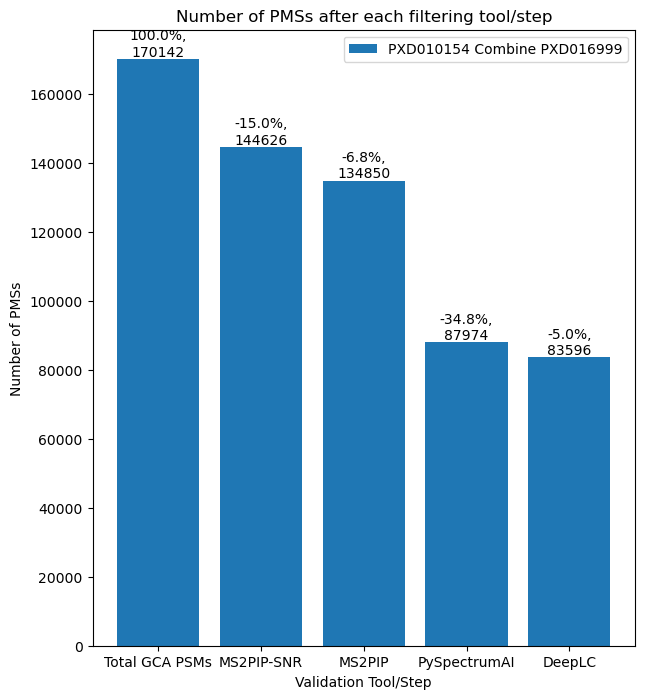

In [162]:
labels = ['Total GCA PSMs','MS2PIP-SNR', 'MS2PIP', 'PySpectrumAI', 'DeepLC']
values1 = [all_gca_number1 + all_gca_number2, 
           ms2pip_SNR_gca_number1 + ms2pip_SNR_gca_number2,
           ms2pip_gca_number1 + ms2pip_gca_number2, 
           ms2pip_spectrumai_gca_number1 + ms2pip_spectrumai_gca_number2, 
           ms2pip_spectrumai_deeplc_gca_number1 + ms2pip_spectrumai_deeplc_gca_number2]
x = np.arange(len(labels)) 
plt.figure(figsize=(7,8))
bar_width = 0.8
bars1 = plt.bar(x , values1, width=bar_width, align='center', label='PXD010154 Combine PXD016999')

plt.title('Number of PMSs after each filtering tool/step')
plt.xlabel('Validation Tool/Step')
plt.ylabel('Number of PMSs')
plt.xticks(x, labels)
plt.legend()
for i,bar in enumerate(bars1):
    num = bar.get_height()
    if i == 0:
        s = "{},\n{}".format("{:.1%}".format(1),num)
        pre = num
    else:
        percentile = (pre - num)/pre 
        s = "-{},\n{}".format("{:.1%}".format(percentile),num)
        pre = num
    plt.text(bar.get_x() + bar.get_width()/2, num, s, ha='center', va='bottom')

plt.savefig('count-plots/combine_filter_count-plot.svg', format='svg')

### Match GCA Infos

In [168]:
PXD010154peps = get_gca_seq_set("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz")
PXD016999peps = get_gca_seq_set("PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz")
print("Number of PXD010154 peptides: {}".format(len(PXD010154peps)))
print("Number of PXD016999 peptides: {}".format(len(PXD016999peps)))
union_peps = PXD010154peps.union(PXD016999peps)
print("Number of union peptides: {}".format(len(union_peps)))
intersection_peps = PXD010154peps.intersection(PXD016999peps)
print("Number of intersection peptides: {}".format(len(intersection_peps)))
onlyPXD010154peps = PXD010154peps - intersection_peps
print("Number of only in PXD010154 peptides: {}".format(len(onlyPXD010154peps)))
onlyPXD016999peps = PXD016999peps - intersection_peps
print("Number of only in PXD016999 peptides: {}".format(len(onlyPXD016999peps)))

Number of PXD010154 peptides: 3989
Number of PXD016999 peptides: 1955
Number of union peptides: 4991
Number of intersection peptides: 953
Number of only in PXD010154 peptides: 3036
Number of only in PXD016999 peptides: 1002


In [171]:
onlyPXD010154peps_list = list(onlyPXD010154peps)
onlyPXD016999peps_list = list(onlyPXD016999peps)
intersection_peps_list = list(intersection_peps)
max_length = max(len(onlyPXD010154peps_list), len(onlyPXD016999peps_list), len(intersection_peps_list))
onlyPXD010154peps_list.extend([None] * (max_length - len(onlyPXD010154peps_list)))
onlyPXD016999peps_list.extend([None] * (max_length - len(onlyPXD016999peps_list)))
intersection_peps_list.extend([None] * (max_length - len(intersection_peps_list)))
pd.DataFrame({
    'only In PXD010154': onlyPXD010154peps_list,
    'only In PXD016999': onlyPXD016999peps_list,
    'In PXD010154 AND PXD016999': intersection_peps_list
}).to_csv("count-tables/peps_in_projects.tsv",index = None,header = 1, sep = "\t")


In [49]:
auto = ahocorasick.Automaton()

for seq in union_peps:
    auto.add_word(seq, seq)

auto.make_automaton()

peps_prots = {}
for prot_file in tqdm(glob('protein_db/GCA_peps/*.fa')):
    prot_seqs = set()
    prots_dict = {}
    parsed_file = SeqIO.parse(prot_file, 'fasta')
    sample_name = prot_file.split('/')[-1].split('-')[1]

    for record in parsed_file:
        try:
            prots_dict[str(record.seq)].append(sample_name + ' ' +  str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description))
        except KeyError:
            prots_dict[str(record.seq)] = [sample_name + ' ' + str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description)]

    #get non-canonical peptides that are found in canonical proteins from ensembl
    found_prots = set()
    
    for prot_seq in prots_dict.keys():
        for end_ind, found in auto.iter(prot_seq):
            found_prots.add(found)
            try:
                peps_prots[found].append(prots_dict[prot_seq])
            except KeyError:
                peps_prots[found] = [prots_dict[prot_seq]]

100%|██████████| 97/97 [03:47<00:00,  2.34s/it]


In [50]:
sample_peps= {}
gene_ID_peps = {}
protein_ID_peps = {}
protein_Seq_peps = {}
transcript_ID_peps = {}
gene_symbol_peps = {}
peps_infos = {}
for pep in tqdm(union_peps):
    prots = [x.split(' ') for xs in peps_prots[pep] for x in xs]
    samples, proteins, proteins_seq, genes, gene_symbols, transcripts, gene_biotypes = set(), set(), set(), set(), set(), set(),set() 
    
    for prot in prots:
        samples.add(prot[0])
        proteins.add(prot[1])
        proteins_seq.add(prot[2])
        genes.add([x for x in prot if x.startswith('gene:')][0].split(':')[-1])
        transcripts.add([x for x in prot if x.startswith('transcript:')][0].split(':')[-1])
        gene_biotypes.add([x for x in prot if x.startswith('gene_biotype:')][0].split(':')[-1])
        
        try:
            gene_symbols.add([x for x in prot if x.startswith('gene_symbol:')][0].split(':')[-1])
        except IndexError:
            pass
    peps_infos[pep] = [','.join(gene_symbols), ','.join(gene_biotypes), ','.join(samples), ','.join(proteins), ','.join(genes), ','.join(transcripts)]

    for sample in samples:
        try:
            sample_peps[sample].add(pep)
        except KeyError:
            sample_peps[sample] = set()
            sample_peps[sample].add(pep)
    
    for gene in genes:
        try:
            gene_ID_peps[gene].add(pep)
        except KeyError:
            gene_ID_peps[gene] = set()
            gene_ID_peps[gene].add(pep)

    for prot_id in proteins:
        try:
            protein_ID_peps[prot_id].add(pep)
        except KeyError:
            protein_ID_peps[prot_id] = set()
            protein_ID_peps[prot_id].add(pep)
    
    for prot_seq in proteins_seq:
        try:
            protein_Seq_peps[prot_seq].add(pep)
        except KeyError:
            protein_Seq_peps[prot_seq] = set()
            protein_Seq_peps[prot_seq].add(pep)
            
    for transcript in transcripts:
        try:
            transcript_ID_peps[transcript].add(pep)
        except KeyError:
            transcript_ID_peps[transcript] = set()
            transcript_ID_peps[transcript].add(pep)
            
    for gene_symbol in gene_symbols:
        try:
            gene_symbol_peps[gene_symbol].add(pep)
        except KeyError:
            gene_symbol_peps[gene_symbol] = set()
            gene_symbol_peps[gene_symbol].add(pep)   

100%|██████████| 4991/4991 [00:06<00:00, 737.22it/s]


In [51]:
print("Number of peptides: {}".format(len(union_peps)))
print("Number of GCA samples matched: {}".format(len(sample_peps)))
print("Number of gene ids matched: {}".format(len(gene_ID_peps)))
print("Number of transcript ids matched: {}".format(len(transcript_ID_peps)))
print("Number of protein ids matched: {}".format(len(protein_ID_peps)))
print("Number of protein seqs matched: {}".format(len(protein_Seq_peps)))
print("Number of gene_symbols matched: {}".format(len(gene_symbol_peps)))

Number of peptides: 4991
Number of GCA samples matched: 97
Number of gene ids matched: 85724
Number of transcript ids matched: 289293
Number of protein ids matched: 289222
Number of protein seqs matched: 29441
Number of gene_symbols matched: 2462


### peps in 97 Samples And 1 Samples

In [52]:
peps_sample_97 = dict()
peps_sample_1 = dict()
for pep,info in peps_infos.items():
    if len(info[2].split(",")) == 97:
        peps_sample_97[pep] =info
    if len(info[2].split(",")) == 1:
        peps_sample_1[pep] =info

In [53]:
print("Number of peptide in Each GCA Sample: {}".format(len(peps_sample_97)))
print("Number of peptide in only one GCA Sample: {}".format(len(peps_sample_1)))

Number of peptide in Each GCA Sample: 83
Number of peptide in only one GCA Sample: 898


In [54]:
peps_sample_df = pd.DataFrame(peps_sample_1).T
peps_sample_df = peps_sample_df.drop(peps_sample_df.columns[[1]], axis=1)
peps_sample_df.columns= ['gene_symbol', 'GCA samples','protein_ID','gene_ID', 'transcript_ID']
peps_sample_df.to_csv("count-tables/peps_in_OneSample.tsv", header=1, sep="\t")

In [55]:
peps_sample_df = pd.DataFrame(peps_sample_97).T
peps_sample_df = peps_sample_df.drop(peps_sample_df.columns[[1]], axis=1)
peps_sample_df.columns= ['gene_symbol', 'GCA samples','protein_ID','gene_ID', 'transcript_ID']
peps_sample_df.to_csv("count-tables/peps_in_EachSample.tsv", header=1, sep="\t")

###  Save Infos

In [56]:
print("Number of peptides: {}".format(len(union_peps)))
print("Number of GCA samples matched: {}".format(len(sample_peps)))
print("Number of gene ids matched: {}".format(len(gene_ID_peps)))
print("Number of transcript ids matched: {}".format(len(transcript_ID_peps)))
print("Number of protein ids matched: {}".format(len(protein_ID_peps)))
print("Number of protein seqs matched: {}".format(len(protein_Seq_peps)))
print("Number of gene_symbols matched: {}".format(len(gene_symbol_peps)))

Number of peptides: 4991
Number of GCA samples matched: 97
Number of gene ids matched: 85724
Number of transcript ids matched: 289293
Number of protein ids matched: 289222
Number of protein seqs matched: 29441
Number of gene_symbols matched: 2462


In [57]:
peps_gene_symbol = pd.DataFrame(list(union_peps), columns=['peptide'])
peps_gene_symbol["gene_symbol"] = peps_gene_symbol["peptide"].apply(lambda x: peps_infos.get(x)[0])
peps_gene_symbol.to_csv("count-tables/peps_gene_symbol.tsv", header=1, sep="\t",index = None)

In [140]:
def create_info_table(info_dict, index, out_file):
    df = pd.DataFrame({'peptides': [','.join(values) for values in info_dict.values()],
                'Count': [len(values) for values in info_dict.values()]},index=info_dict.keys())
    df.index.name = index
    df.sort_values('Count', ascending=False, inplace=True)
    df.to_csv(out_file, header=1, sep="\t")

In [59]:
create_info_table(sample_peps,"GCA_sample","count-tables/sample_peps.tsv")
create_info_table(gene_ID_peps,"gene_ID","count-tables/gene_ID_peps.tsv")
create_info_table(transcript_ID_peps,"transcript_ID","count-tables/transcript_ID_peps.tsv")
create_info_table(protein_ID_peps,"protein_ID","count-tables/protein_ID_peps.tsv")
create_info_table(protein_Seq_peps,"protein_Seq","count-tables/protein_Seq_peps.tsv")
create_info_table(gene_symbol_peps,"gene_symbol","count-tables/gene_symbol_peps.tsv")

In [60]:
gene_symbol_peps_df = pd.read_table("count-tables/gene_symbol_peps.tsv")
gene_symbol_peps_df = gene_symbol_peps_df[gene_symbol_peps_df['Count']>=10].sort_values('Count', ascending=False)

print("Number of gene_symbol with more than 10 peptides: {}".format(len(gene_symbol_peps_df)))

Number of gene_symbol with more than 10 peptides: 39


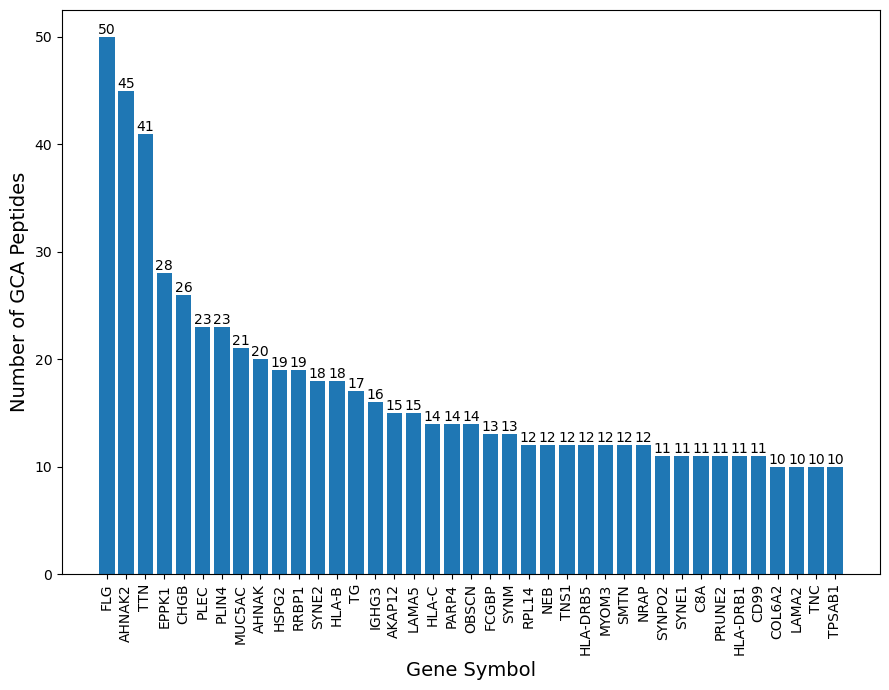

In [61]:
plt.figure(figsize=(9,7))
bar_width = 0.8
bars = plt.bar(gene_symbol_peps_df['gene_symbol'],gene_symbol_peps_df['Count'], width=bar_width, align='center')
plt.xlabel('Gene Symbol', fontsize=14)  
plt.ylabel('Number of GCA Peptides', fontsize=14) 
plt.xticks(rotation='vertical')  
plt.tight_layout()  
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.savefig('count-plots/gene_sybol-peps-plot.svg', format='svg')

In [62]:
gene_symbol_peps_df = pd.read_table("count-tables/gene_symbol_peps.tsv")
gene_symbol_peps_df["peptides"] = gene_symbol_peps_df["peptides"].apply(lambda x : set(x.split(",")))

def get_tissue_validated_PSMs(file1,file2,save_path):
    df1 = pd.read_table(file1, sep = "," ,compression="gzip", usecols = ["sequence","usi"])
    df2 = pd.read_table(file2, sep = "," ,compression="gzip", usecols = ["sequence","usi"])

    df = pd.concat([df1,df2],axis = 0)
    df = df.drop_duplicates()
    return df["sequence"].value_counts()

tissue_psms_count = get_tissue_validated_PSMs("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz",
                "PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz",
                "count-tables/aaa")

def get_tissue_validated_PSMs_number(sequence_set, value_counts):
    num = 0
    for seq in sequence_set:
        num += value_counts[seq]
    return num

gene_symbol_peps_df["PSMs_Count"] = gene_symbol_peps_df["peptides"].apply(lambda x : get_tissue_validated_PSMs_number(x, tissue_psms_count))
gene_symbol_peps_df["peptides"] = gene_symbol_peps_df["peptides"].apply(lambda x : ",".join(x))

gene_symbol_peps_df.to_csv("count-tables/gene_symbol_peps.tsv", header=1, sep="\t",index = None)

### PeptideAtlas Count

In [23]:
column_names = ['PeptideAccession', 'observations', 'best score', 'peptide sequence','']
PeptideAtlas = pd.read_table("protein_db/PeptideAtlasInput_concat.PAidentlist.peptideSummary",header=None,names=column_names)
PeptideAtlas_dict = dict(zip(PeptideAtlas['peptide sequence'], PeptideAtlas['observations']))

In [24]:
peps_PeptideAtlas = pd.DataFrame(list(union_peps), columns=['sequence'])
peps_PeptideAtlas["PeptideAtlas Observations"] = peps_PeptideAtlas['sequence'].apply(lambda x: PeptideAtlas_dict[x] if PeptideAtlas_dict.get(x) else 0)

peps_PeptideAtlas.to_csv("count-tables/peps_PeptideAtlas.tsv", header=1, sep="\t",index = None)

In [25]:
print("Number of observations<=10 GCA peptide:",len(peps_PeptideAtlas[peps_PeptideAtlas['PeptideAtlas Observations']<=10]))

Number of observations<=10 GCA peptide: 3318


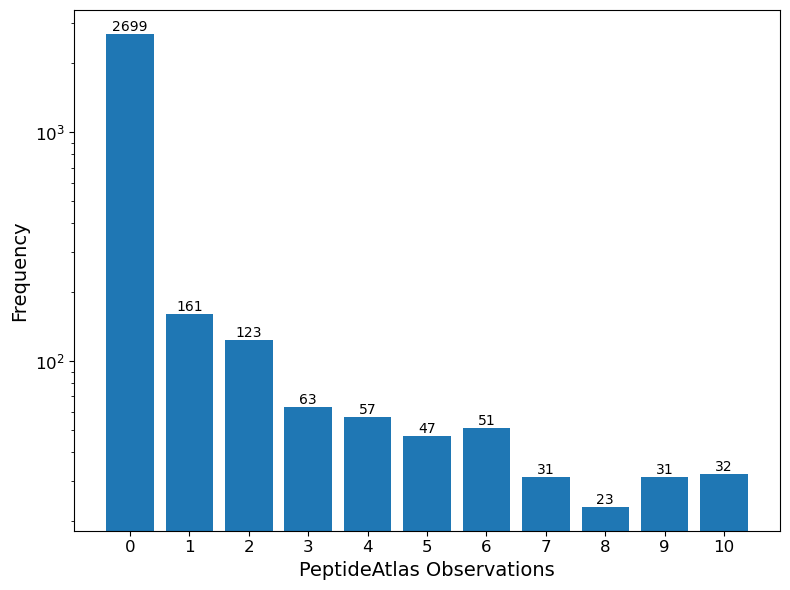

In [26]:
value_counts = peps_PeptideAtlas[peps_PeptideAtlas['PeptideAtlas Observations']<=10]['PeptideAtlas Observations'].value_counts()

plt.figure(figsize=(8,6))

bars = plt.bar(value_counts.index, value_counts.values)
plt.xlabel('PeptideAtlas Observations', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.xticks(value_counts.index, fontsize=12) 
plt.yticks(fontsize=12)
plt.tight_layout()  
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.savefig('count-plots/peps_PeptideAtlas-plot.svg', format='svg')
plt.show()

In [27]:
print("Number of observations=0 GCA peptide:",len(peps_PeptideAtlas[peps_PeptideAtlas['PeptideAtlas Observations']==0]))
print("Number of 0<observations<=10 GCA peptide:",len(peps_PeptideAtlas[(peps_PeptideAtlas['PeptideAtlas Observations']<=10) & (peps_PeptideAtlas['PeptideAtlas Observations']>0)]))

Number of observations=0 GCA peptide: 2699
Number of 0<observations<=10 GCA peptide: 619


### Tissue Count

In [124]:
sdrf_010154 = pd.read_table("PXD010154/sdrf_parquet/PXD010154.sdrf.tsv")
sdrf_016999_first = pd.read_table("PXD016999/sdrf_parquet/PXD016999-first-instrument.sdrf.tsv")

sdrf_016999_second = pd.read_table("PXD016999/sdrf_parquet/PXD016999-second-instrument.sdrf.tsv")
sdrf_016999 = pd.concat([sdrf_016999_first, sdrf_016999_second], axis=0, ignore_index=True)
sdrf_016999 = sdrf_016999[(sdrf_016999["characteristics[organism part]"]!="Empty") & (sdrf_016999["characteristics[organism part]"]!="Norm")]

In [125]:
def get_sdrf_info(sdrf):
    sdrf["reference_file_name"] = sdrf['comment[data file]'].str.split(".", expand=True)[0]
    file_tissue = sdrf[['characteristics[organism part]','reference_file_name']].drop_duplicates()
    file_tissue = file_tissue.groupby('reference_file_name')['characteristics[organism part]'].apply(list).reset_index()
    
    file_sample = sdrf[['source name','reference_file_name']].drop_duplicates()
    file_sample = file_sample.groupby('reference_file_name')['source name'].apply(list).reset_index()
    
    # file_tissue_map: file -> tissue
    file_tissue_map = file_tissue.set_index('reference_file_name').to_dict()['characteristics[organism part]']
    # file_sample_map: file -> sample
    file_sample_map = file_sample.set_index('reference_file_name').to_dict()['source name']

    # tissue_fileNumbers: tissue -> files_number
    tissue_fileNumbers = sdrf[['characteristics[organism part]','reference_file_name']].drop_duplicates()['characteristics[organism part]'].value_counts()
    # tissue_sampleNumbers: tissue -> samples_number
    tissue_sampleNumbers = sdrf[['characteristics[organism part]','source name']].drop_duplicates()['characteristics[organism part]'].value_counts()

    tissue_file = sdrf[['characteristics[organism part]','reference_file_name']].drop_duplicates()
    tissue_file = tissue_file.groupby('characteristics[organism part]')['reference_file_name'].apply(list).reset_index()
    # tissue_file_map: tissue -> file
    tissue_file_map = tissue_file.set_index('characteristics[organism part]').to_dict()['reference_file_name']
    
    return [file_tissue_map, file_sample_map, tissue_fileNumbers, tissue_sampleNumbers, tissue_file_map]

In [126]:
PXD010154_sdrf_info = get_sdrf_info(sdrf_010154)
PXD016999_sdrf_info = get_sdrf_info(sdrf_016999)

In [127]:
def plot_combine_PSMs(parquet_file1, parquet_file2, parquet_file3, sdrf_info, path):
    table1 = pq.read_table(parquet_file1, columns=["reference_file_name"])
    parquet1 = table1.to_pandas()

    table2 = pq.read_table(parquet_file2, columns=["reference_file_name"])
    parquet2 = table2.to_pandas()

    table3 = pq.read_table(parquet_file3, columns=["reference_file_name"])
    parquet3 = table3.to_pandas()

    from_parquet = pd.concat([parquet1, parquet2, parquet3], axis=0, ignore_index=True)

    from_parquet["organism part"] = from_parquet["reference_file_name"].map(sdrf_info[0])
    from_parquet = from_parquet.explode("organism part", ignore_index=True)

    value_counts = from_parquet['organism part'].value_counts()

    unique_keys = value_counts.index.tolist()
    nums_list = [sdrf_info[2].get(key, "") for key in unique_keys]

    plt.figure(figsize=(10,9))
    bar_width = 0.8
    bars = plt.bar(value_counts.index, value_counts.values)
    plt.xlabel('Tissue', fontsize=14)
    plt.ylabel('Number of PSMs', fontsize=14)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    for i,bar in zip(nums_list,bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(i), ha='center', va='bottom', fontsize=8)
        
    plt.xticks(rotation='vertical')  
    plt.tight_layout()  
    plt.savefig(path, format='svg')
    plt.show()

In [128]:
def plot_PSMs(parquet_file1, parquet_file2, sdrf_info, path):
    if parquet_file2:
        table1 = pq.read_table(parquet_file1, columns=["reference_file_name"])
        parquet1 = table1.to_pandas()

        table2 = pq.read_table(parquet_file2, columns=["reference_file_name"])
        parquet2 = table2.to_pandas()

        from_parquet = pd.concat([parquet1, parquet2], axis=0, ignore_index=True)
    else:
        table = pq.read_table(parquet_file1, columns=["reference_file_name"])
        from_parquet = table.to_pandas()

    from_parquet["organism part"] = from_parquet["reference_file_name"].map(sdrf_info[0])
    from_parquet = from_parquet.explode("organism part", ignore_index=True)

    value_counts = from_parquet['organism part'].value_counts()

    unique_keys = value_counts.index.tolist()
    nums_list = [sdrf_info[2].get(key, "") for key in unique_keys]

    plt.figure(figsize=(10,9))
    bar_width = 0.8
    bars = plt.bar(value_counts.index, value_counts.values)
    plt.xlabel('Tissue', fontsize=14)
    plt.ylabel('Number of PSMs', fontsize=14)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    for i,bar in zip(nums_list,bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(i), ha='center', va='bottom', fontsize=8)
        
    plt.xticks(rotation='vertical')  
    plt.tight_layout()  
    plt.savefig(path, format='svg')
    plt.show()

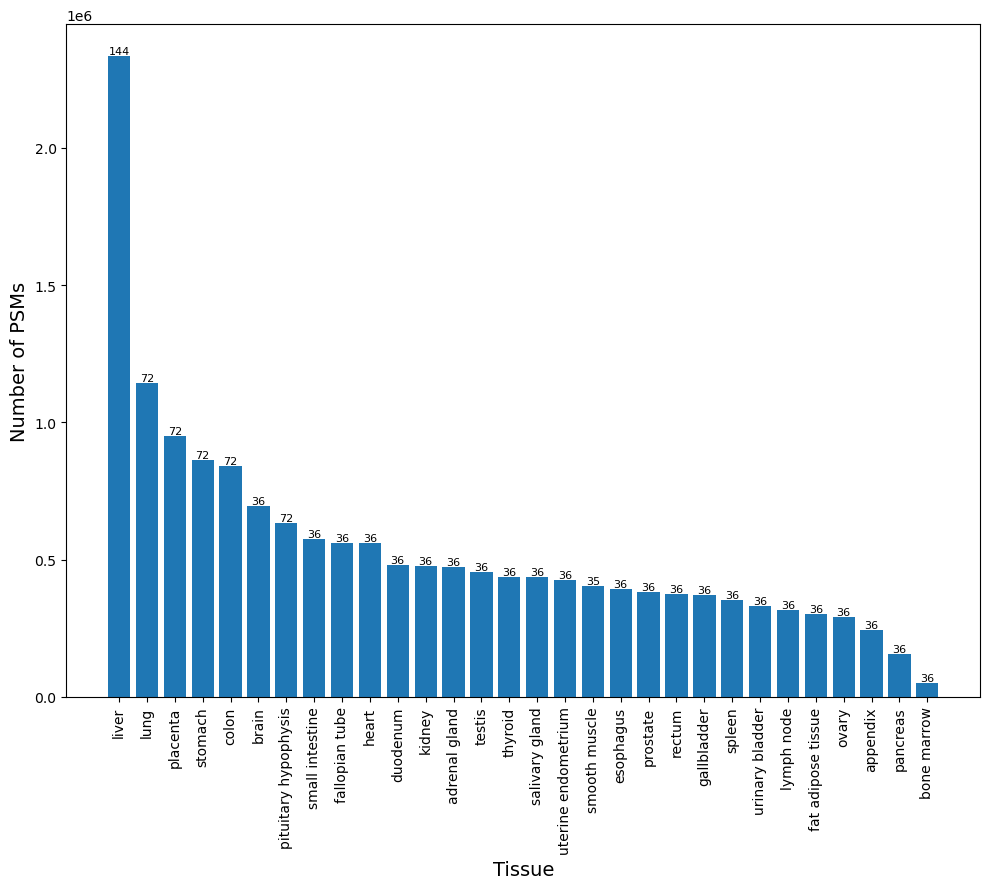

In [129]:
plot_PSMs("PXD010154/sdrf_parquet/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet",
         False,
         PXD010154_sdrf_info, "count-plots/PXD010154-tissue_PSMs-plot.svg")

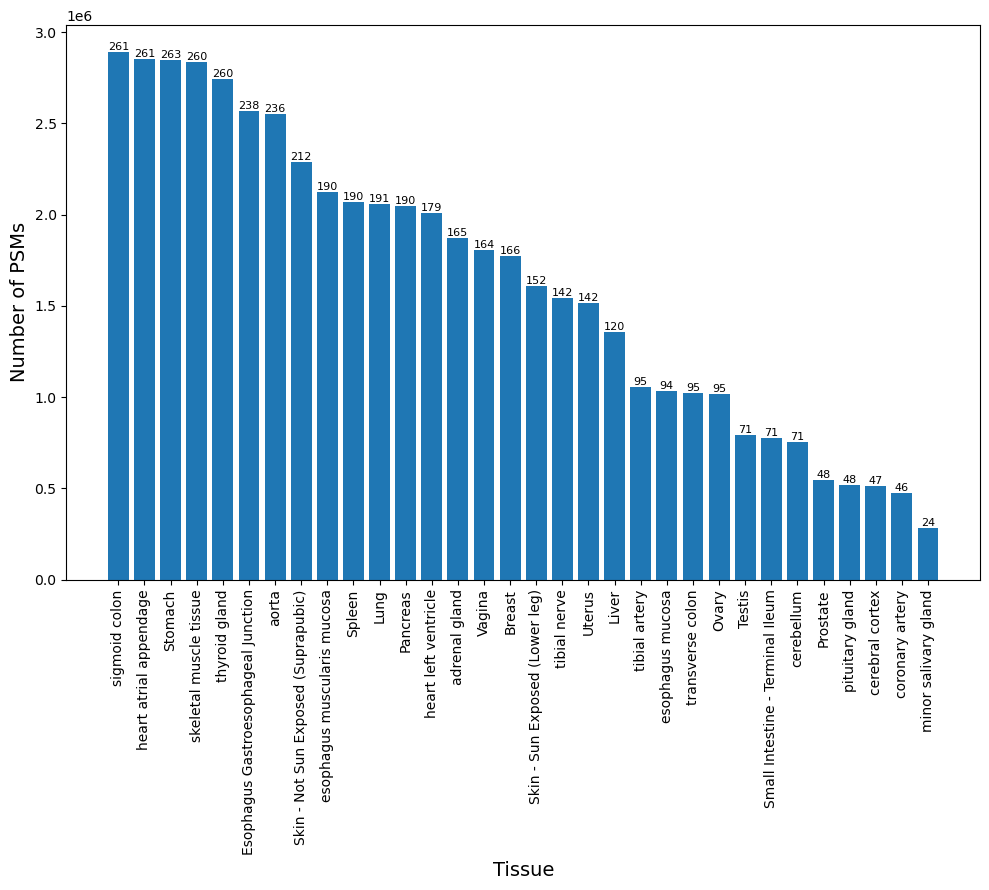

In [130]:
plot_PSMs("PXD016999/sdrf_parquet/PXD016999-first-instrument-8b005cd8-d641-4d1e-a085-c92ed045b4da.psm.parquet",
         "PXD016999/sdrf_parquet/PXD016999-second-instrument-2739df94-8ceb-4033-a8d3-91adba121f3f.psm.parquet",
         PXD016999_sdrf_info, "count-plots/PXD016999-tissue_PSMs-plot.svg")

In [131]:
def plot_Spectra(RAWs_PATH, sdrf_info, path):
    tissue_MS = dict()
    for tissue,mzmls in tqdm(sdrf_info[4].items()):
        msms_num = 0
        for mzml in mzmls:
            file_path = RAWs_PATH + mzml.split(".")[0] + '.mzML'
            exp = MSExperiment()
            if os.path.exists(file_path):
                try:
                    MzMLFile().load(file_path, exp)
                    for scan in exp:
                        if scan.getMSLevel() == 2:  
                            msms_num += 1
                except RuntimeError:
                    print(file_path + "ERROR！")
            else:
                # print(file_path + "not found")
                continue
                
        tissue_MS[tissue] = msms_num
    
    sorted_tissue_MS = sorted(tissue_MS.items(), key=lambda x: x[1], reverse=True)
    sorted_tissues = [tissue[0] for tissue in sorted_tissue_MS]
    sorted_values = [tissue[1] for tissue in sorted_tissue_MS]

    plt.figure(figsize=(10,9))
    bar_width = 0.8
    bars = plt.bar(sorted_tissues, sorted_values, width=bar_width, align='center')
    plt.xlabel('Tissue', fontsize=14)  
    plt.ylabel('Number of Spectra', fontsize=14) 
    plt.xticks(rotation='vertical', fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.tight_layout()  
    
    nums_list = [sdrf_info[2].get(tissue, "") for tissue in sorted_tissues]
    
    for i,bar in zip(nums_list,bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(i), ha='center', va='bottom', fontsize=8)
    
    plt.savefig(path, format='png')

In [132]:
# plot_Spectra("/home1/wangd/project/PXD010154/", PXD010154_sdrf_info, "count-plots/PXD010154-tissue_Spectra-plot.svg")

In [133]:
# plot_Spectra("/home1/wangd/project/PXD016999/", PXD016999_sdrf_info, "count-plots/PXD016999-tissue_Spectra-plot.svg")

In [134]:
print("Number of Total RAWs: {}".format(sdrf_010154['comment[data file]'].nunique() + sdrf_016999['comment[data file]'].nunique()))
print("Number of PXD010154 RAWs: {}".format(sdrf_010154['comment[data file]'].nunique()))
print("Number of PXD016999 RAWs: {}".format(sdrf_016999['comment[data file]'].nunique()))

print("Number of PXD010154 tissue RAWs: {}".format(len(PXD016999_sdrf_info[0])))
print("Number of PXD016999 tissue RAWs: {}".format(len(PXD016999_sdrf_info[0])))

Number of Total RAWs: 2031
Number of PXD010154 RAWs: 1367
Number of PXD016999 RAWs: 664
Number of PXD010154 tissue RAWs: 664
Number of PXD016999 tissue RAWs: 664


In [135]:
def plot_RAWs(sdrf_info, path):
    sorted_tissue_files = sorted(sdrf_info[2].items(), key=lambda x: x[1], reverse=True)
    sorted_tissues = [tissue[0] for tissue in sorted_tissue_files]
    sorted_values = [tissue[1] for tissue in sorted_tissue_files]
    
    plt.figure(figsize=(10,9))
    bar_width = 0.8
    bars = plt.bar(sorted_tissues, sorted_values, width=bar_width, align='center')
    plt.xlabel('Tissue', fontsize=14)  
    plt.ylabel('Number of RAWs', fontsize=14) 
    plt.xticks(rotation='vertical', fontsize=10)  
    plt.yticks(fontsize=10) 
    plt.tight_layout()  
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

    plt.savefig(path, format='png')

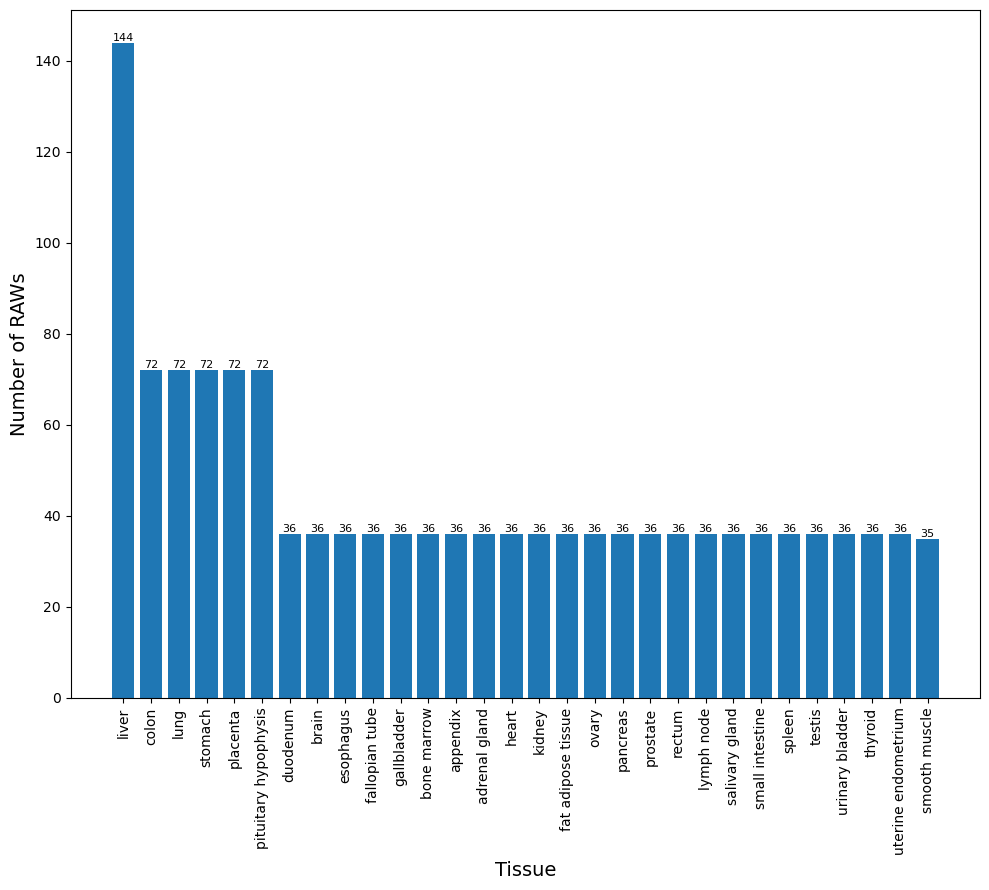

In [136]:
plot_RAWs(PXD010154_sdrf_info, "count-plots/PXD010154-tissue_RAWs-plot.svg")

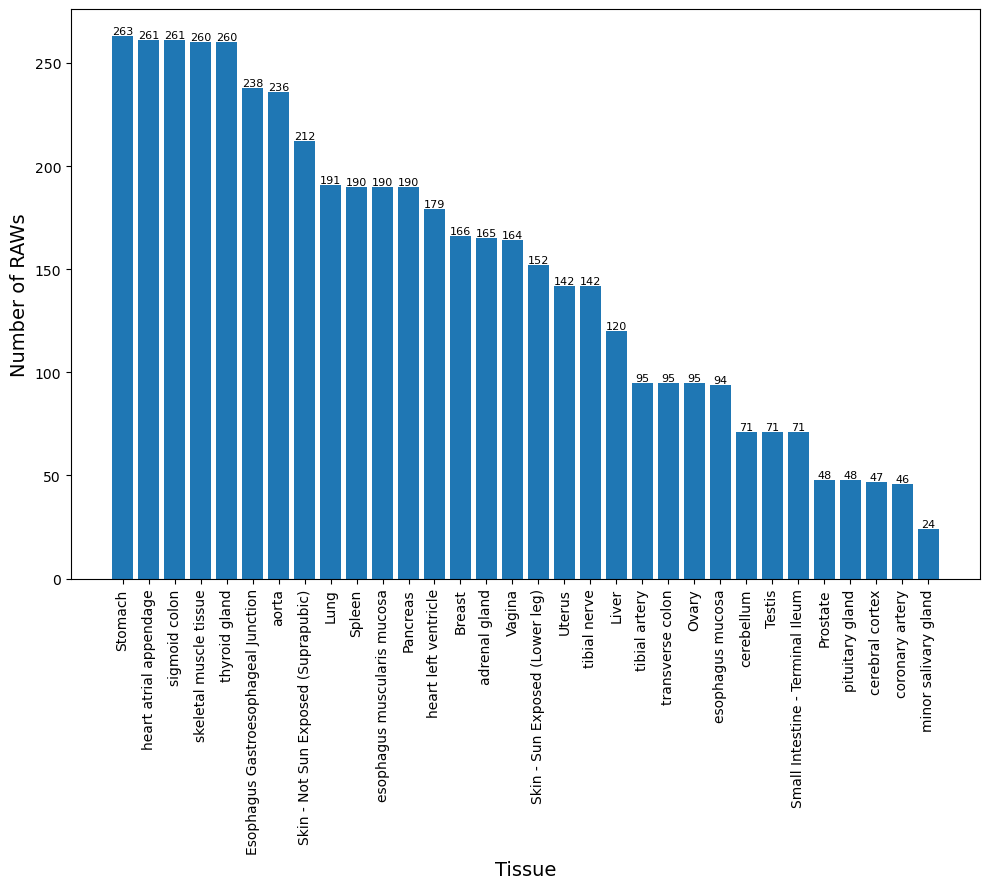

In [137]:
plot_RAWs(PXD016999_sdrf_info, "count-plots/PXD016999-tissue_RAWs-plot.svg")

In [138]:
def save_tissue_file_peps(file, sdrf_info, reference_file_peps_path ,tissue_peps_path):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    df = df[['sequence','reference_file_name']].drop_duplicates()

    reference_file_pep_info = {}
    tissue_pep_info = {}
    for index, row in df.iterrows():
        sequence = row["sequence"]
        reference_file = row["reference_file_name"]
        tissues = sdrf_info[0][reference_file]
        
        if reference_file_pep_info.get(reference_file):
            reference_file_pep_info[reference_file].add(sequence)
        else:
            reference_file_pep_info[reference_file]= set()
            reference_file_pep_info[reference_file].add(sequence)
            
        for tissue in tissues:
            if tissue_pep_info.get(tissue):
                tissue_pep_info[tissue].add(sequence)
            else:
                tissue_pep_info[tissue]= set()
                tissue_pep_info[tissue].add(sequence)
                
    create_info_table(reference_file_pep_info, "reference_file", reference_file_peps_path)
    create_info_table(tissue_pep_info, "tissue", tissue_peps_path)
    
    tissue_pep = pd.read_table(tissue_peps_path)
    tissue_pep["RAWs_nums"] = tissue_pep["tissue"].map(sdrf_info[2])
    tissue_pep["Sample_nums"] = tissue_pep["tissue"].map(sdrf_info[3])
    tissue_pep.to_csv(tissue_peps_path, header=1, sep="\t",index = None)

In [141]:
save_tissue_file_peps("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz", 
                      PXD010154_sdrf_info, 
                      "count-tables/PXD010154-reference_file_peps.tsv",
                      "count-tables/PXD010154-tissue_peps.tsv")

save_tissue_file_peps("PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz", 
                      PXD016999_sdrf_info, 
                      "count-tables/PXD016999-reference_file_peps.tsv",
                      "count-tables/PXD016999-tissue_peps.tsv")

In [142]:
combine_tissue_set = {'brain','colon','duodenum','esophagus','gallbladder','heart','kidney','liver','lung',
 'ovary','pancreas','placenta','prostate','rectum','small intestine','spleen','stomach','testis'}

PXD016999_rename_tissue = {"sigmoid colon" : "colon", "transverse colon" : "colon",
                           "Esophagus Gastroesophageal Junction" : "esophagus", "esophagus muscularis mucosa" : "esophagus","esophagus mucosa" : "esophagus",
                           "heart left ventricle" : "heart", "heart atrial appendage" : "heart", 
                           "Liver" : "liver", "Lung" : "lung", "Ovary" : "ovary", "Pancreas":"pancreas", 
                           "Prostate" : "prostate", "Small Intestine - Terminal Ileum" :  "small intestine",
                           "Spleen":"spleen","Stomach":"stomach", "Testis":"testis"}

In [143]:
frecuent_tissues_peps_df = pd.concat([pd.read_table("count-tables/PXD010154-tissue_peps.tsv"),
                    pd.read_table("count-tables/PXD016999-tissue_peps.tsv")],axis = 0)
frecuent_tissues_peps_df['peptides'] = frecuent_tissues_peps_df["peptides"].apply(lambda x: set(x.split(",")))

tissues_peps = frecuent_tissues_peps_df.set_index('tissue')['peptides'].to_dict()
for tissue, peps in tissues_peps.items():
    if tissue in PXD016999_rename_tissue:
        rename_tissue = PXD016999_rename_tissue[tissue]
        tissues_peps[rename_tissue] = tissues_peps[rename_tissue].union(peps)
frecuent_tissues_peps = {key: value for key, value in tissues_peps.items() if key in combine_tissue_set}

In [144]:
create_info_table(frecuent_tissues_peps, "tissue", "count-tables/combine_frecuent_tissue_peps.tsv")

In [146]:
frecuent_PXD010154_tissues_peps_df = pd.read_table("count-tables/PXD010154-tissue_peps.tsv")
frecuent_PXD010154_tissues_peps_df['peptides'] = frecuent_PXD010154_tissues_peps_df["peptides"].apply(lambda x: set(x.split(",")))

tissues_PXD010154_peps = frecuent_PXD010154_tissues_peps_df.set_index('tissue')['peptides'].to_dict()
frecuent_PXD010154_tissues_peps = {key: value for key, value in tissues_PXD010154_peps.items() if key in combine_tissue_set}

In [147]:
create_info_table(frecuent_PXD010154_tissues_peps, "tissue", "count-tables/PXD010154_frecuent_tissue_peps.tsv")

In [148]:
def plot_final_peps(file, path, add_RAWs_nums = True):
    df = pd.read_table(file)
    index = df.columns[0]
    df = df.sort_values('Count', ascending=False)
    
    plt.figure(figsize=(16,10))
    bar_width = 0.8
    plt.bar(df[index], df['Count'], width=bar_width, align='center')
    plt.xlabel(index, fontsize=18)  
    plt.ylabel('Number of GCA peptides', fontsize=18) 
    plt.xticks(rotation='vertical', fontsize = 18)  
    plt.yticks(fontsize = 18)  
    
    plt.tight_layout()  
    if add_RAWs_nums:
        for i, (count, num) in enumerate(zip(df['Count'], df['RAWs_nums'])):
            plt.text(i, count, f"{count}\n({num})", ha='center', va='bottom', fontsize=10)
    else:
        for i, count in enumerate(df['Count']):
            plt.text(i, count, f"{count}", ha='center', va='bottom', fontsize=10)
    plt.savefig(path, format='svg')

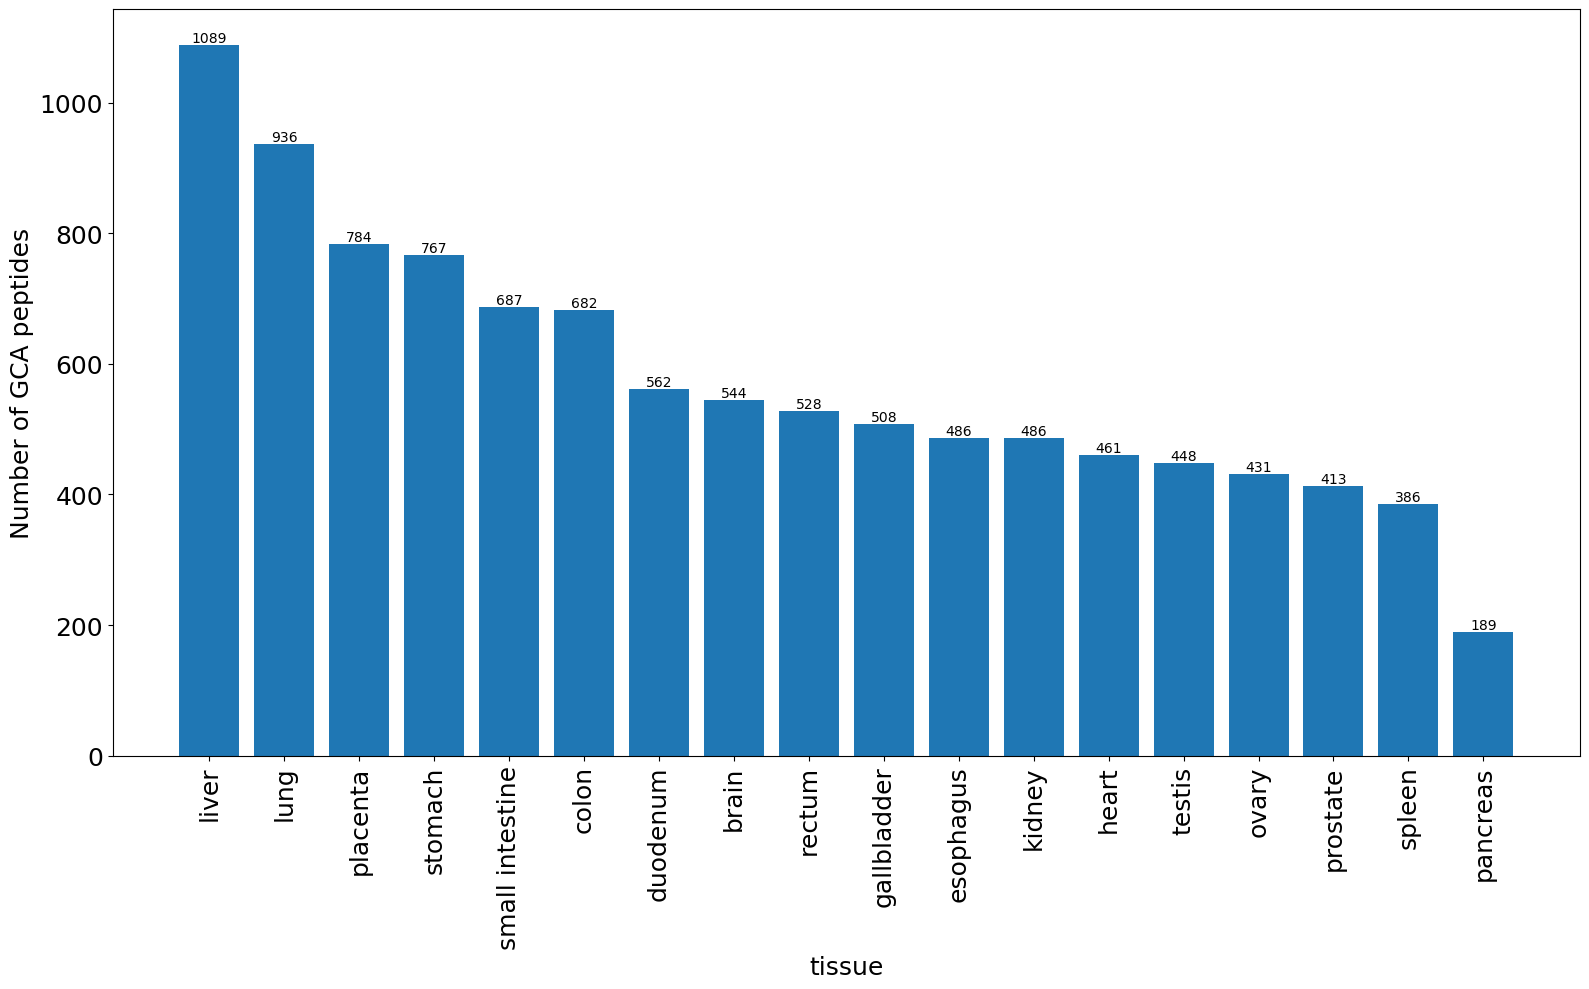

In [153]:
plot_final_peps("count-tables/PXD010154_frecuent_tissue_peps.tsv", "count-plots/PXD010154-frecuent_tissue_peps-plot.svg",False)

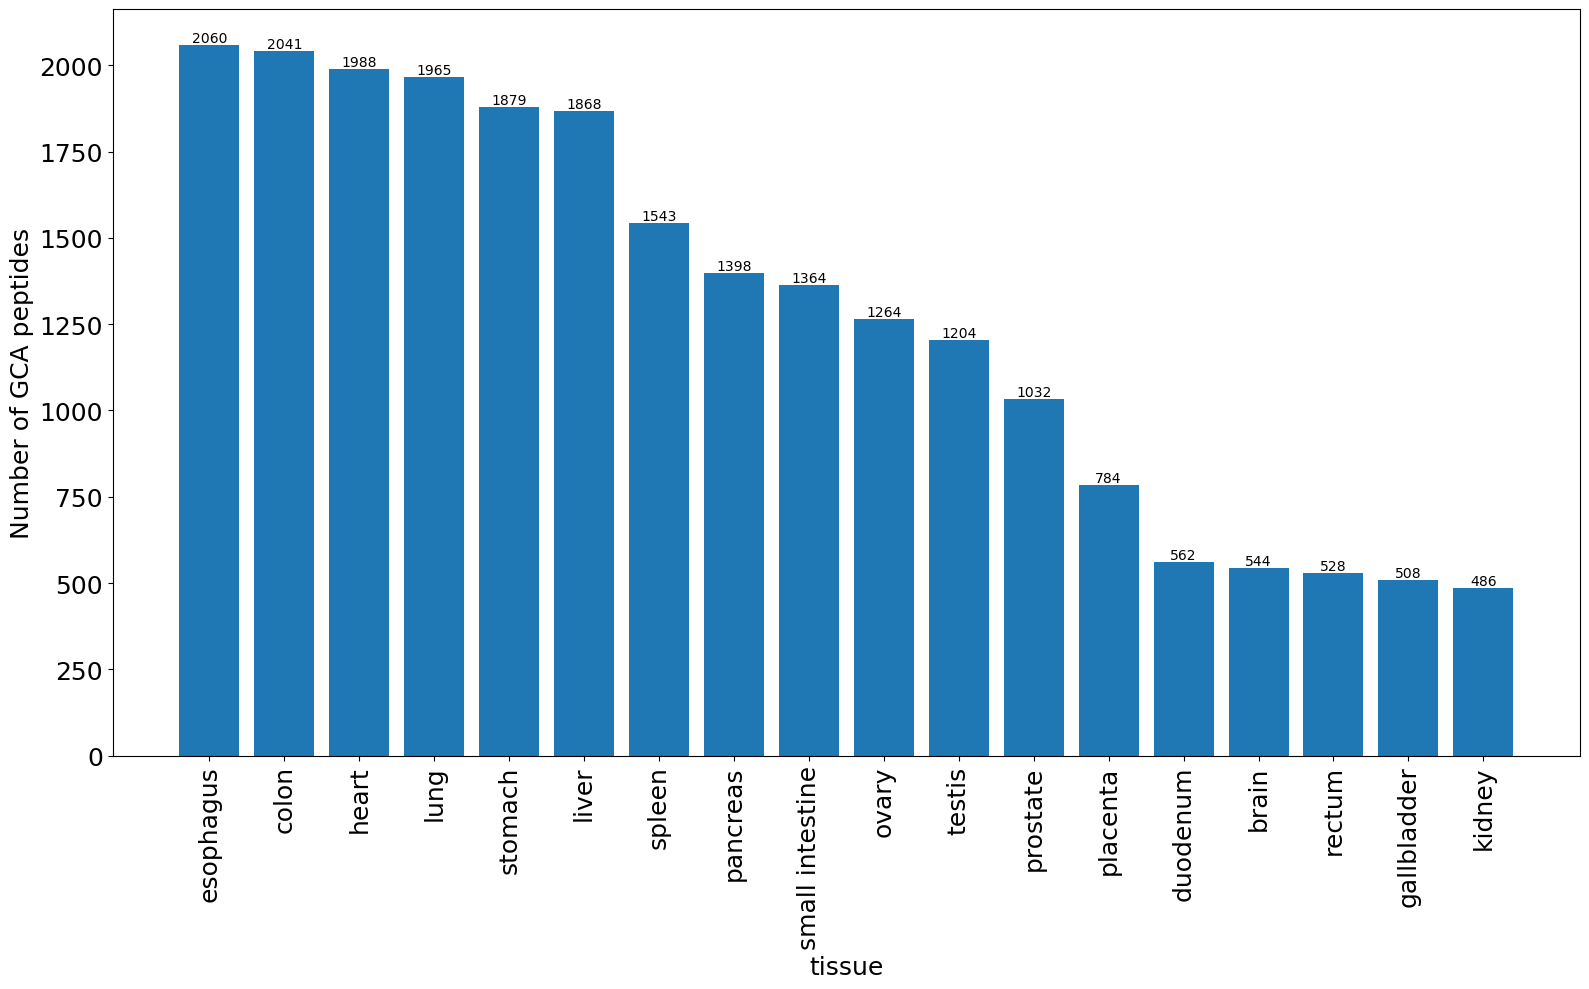

In [149]:
plot_final_peps("count-tables/combine_frecuent_tissue_peps.tsv", "count-plots/combine-frecuent_tissue_peps-plot.svg", False)

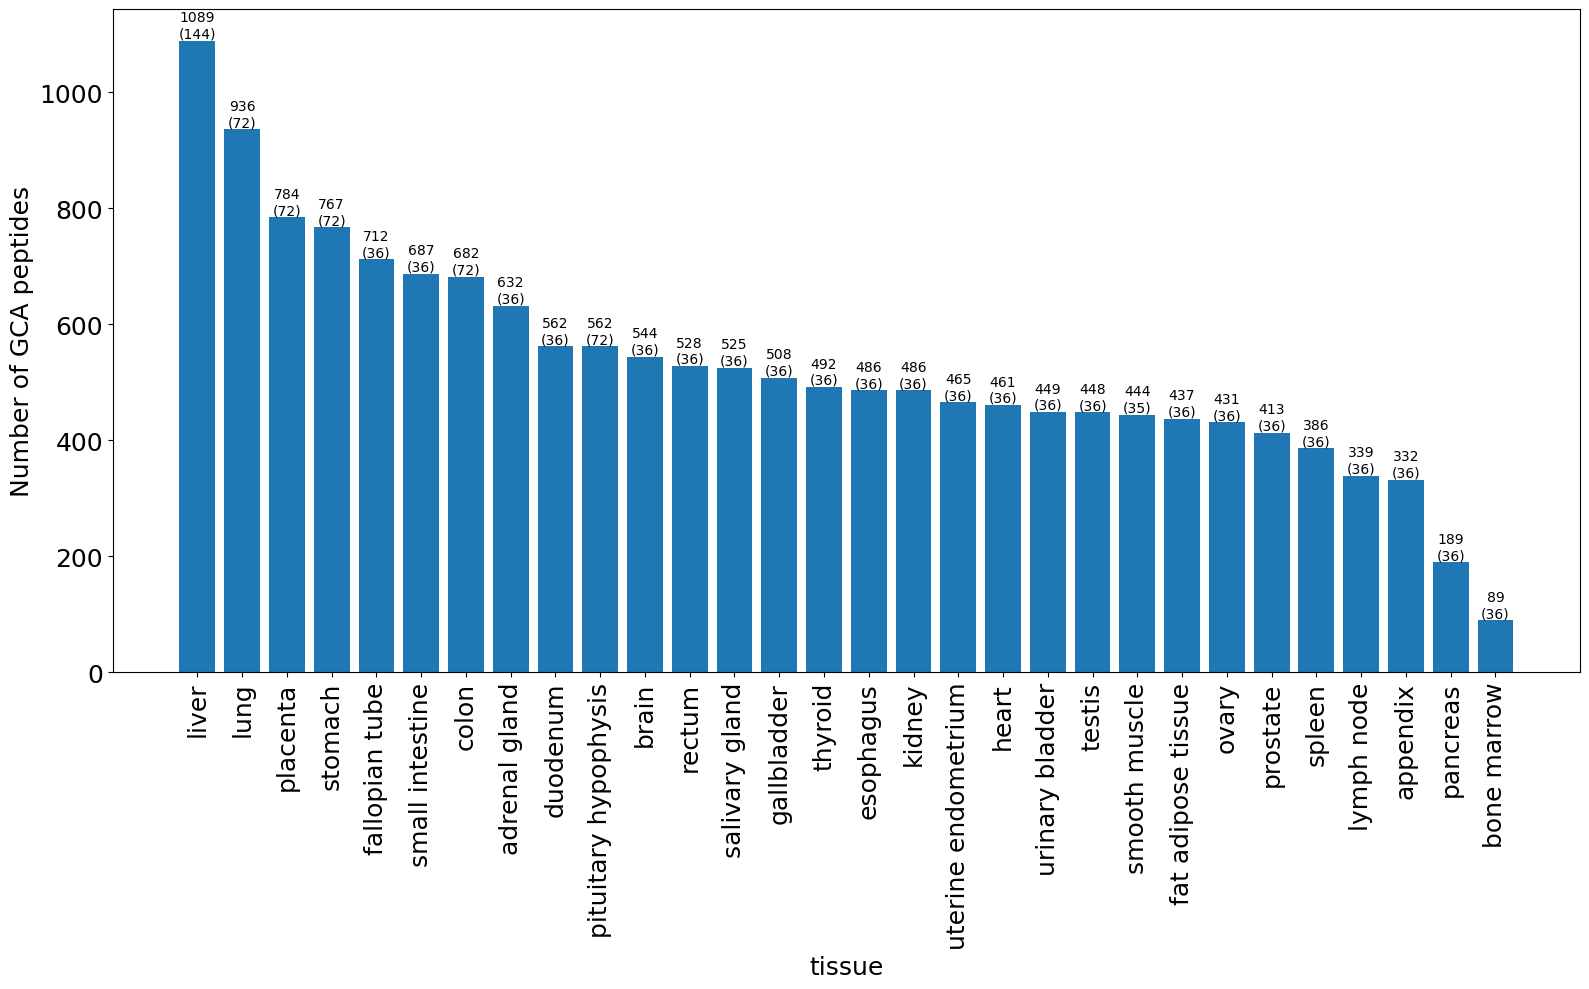

In [150]:
plot_final_peps("count-tables/PXD010154-tissue_peps.tsv", "count-plots/PXD010154-tissue_peps-plot.svg")

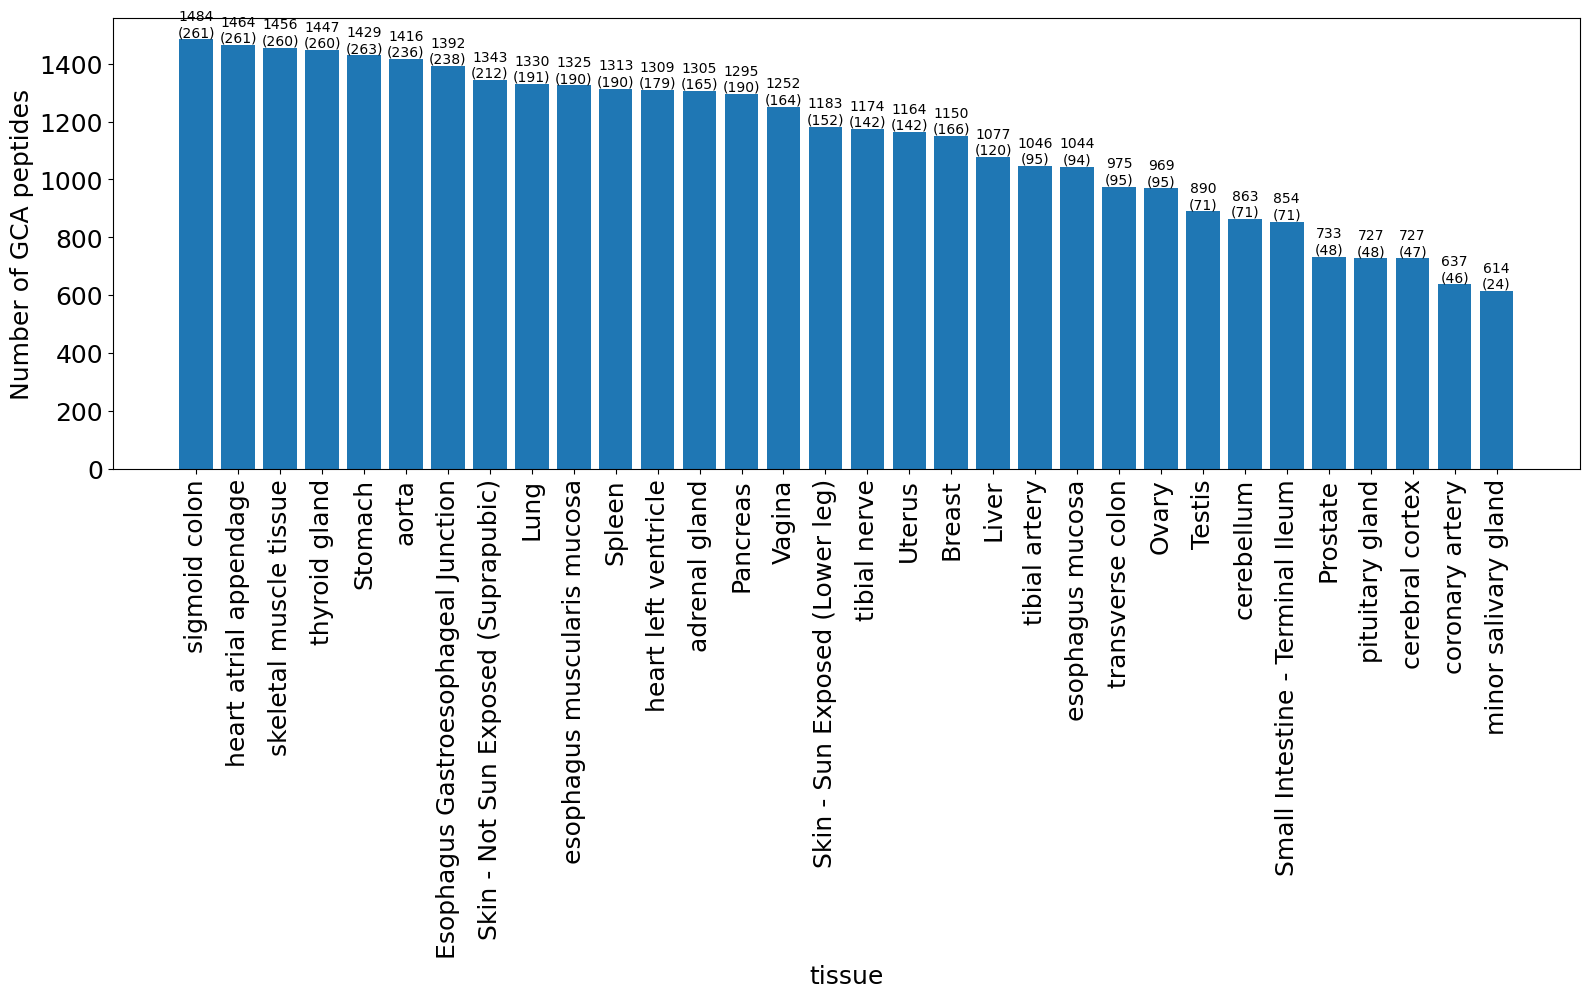

In [151]:
plot_final_peps("count-tables/PXD016999-tissue_peps.tsv", "count-plots/PXD016999-tissue_peps-plot.svg")

### GCA Sample Count

In [51]:
def get_group_peps_number(group):
    pep_unique = set()
    for peps in group["peptides"].to_list():
        pep_unique = pep_unique.union(set(peps.split(",")))
    return len(pep_unique)  

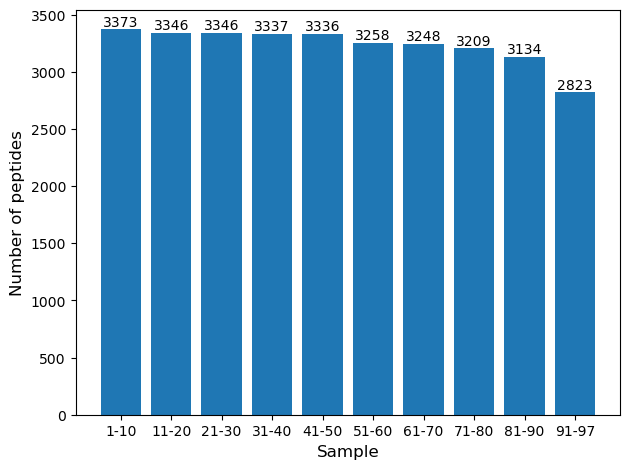

In [52]:
df = pd.read_table("count-tables/sample_peps.tsv")
df = df.sort_values('Count', ascending=False)
bar_width = 0.9

groups = [df.iloc[i:i+10] for i in range(0, len(df), 10)]

group_sums = [get_group_peps_number(group) for group in groups]
group_sums =  sorted(group_sums, reverse=True)
plt.bar(range(1, 11), group_sums)
for i, group_sum in enumerate(group_sums):
    plt.text(i + 1, group_sum, str(group_sum), ha='center', va='bottom')
    
plt.xlabel('Sample',fontsize = 12)
plt.ylabel('Number of peptides',fontsize = 12)
plt.xticks(range(1, 11), ['{}-{}'.format(i*10+1, min((i+1)*10, 97)) for i in range(10)], fontsize = 10)
plt.tight_layout()  

plt.savefig('count-plots/gca_sample-plot.svg', format='svg')

### Variation Type Count

In [53]:
PXD010154_final_peps = pd.read_table("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz", sep = "," ,compression="gzip")
PXD016999_final_peps = pd.read_table("PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz", sep = "," ,compression="gzip")
non_canonical_peps = set(PXD010154_final_peps[PXD010154_final_peps["position"]=="non-canonical"]["seq"]).union(
                        set(PXD016999_final_peps[PXD016999_final_peps["position"]=="non-canonical"]["seq"]))
single_AA_substitution_peps = union_peps - non_canonical_peps
print("Number of single_AA_substitution_peptides: {}".format(len(single_AA_substitution_peps)))
print("Number of non_canonical_peptidess: {}".format(len(non_canonical_peps)))

Number of single_AA_substitution_peptides: 4572
Number of non_canonical_peptidess: 419


In [54]:
len(non_canonical_peps)

419

In [55]:
fasta_dict = dict()
for j in SeqIO.parse("protein_db/Grch38+UP000005640_9606_additional.fa", "fasta"):
    if fasta_dict.get(str(j.seq)):
        fasta_dict[str(j.seq)].add(j.id)
    else:
        fasta_dict[str(j.seq)] = {j.id}

In [56]:
def get_insertion_deletion_peptide(fasta, peptide):
    length = len(peptide)
    if len(fasta) >= length-1:    
        score1 = pairwise2.align.localms(sequenceA=fasta, sequenceB=peptide, 
                                                       match=1, mismatch=-3, open=-1, extend=-1, score_only=True)
        if score1 == length-1:
            score2 = pairwise2.align.localms(sequenceA=fasta, sequenceB=peptide, 
                                                       match=4, mismatch=-3, open=-2, extend=-2, score_only=True)
            # Exclude the second amino acid deletion at start or end
            if score2 == length*4-2:
                return "deletion"
        elif score1 == length-2:
            score2 = pairwise2.align.localms(sequenceA=fasta, sequenceB=peptide, 
                                                       match=4, mismatch=-3, open=-2, extend=-2, score_only=True)
            # Exclude the second amino acid deletion 2 AA at middle
            if score2 != length*4-2*2:
                return "insertion"
        else:
            return "novel"
    return "novel"

In [57]:
def get_insertion_deletion_peptide_proteins(fasta_dict, peptide):
    types = set()
    for fasta in fasta_dict.keys():
        type = get_insertion_deletion_peptide(fasta, peptide)
        types.add(type)
    if "deletion" in types and "insertion" in types:
        return "deletion,insertion"
    elif "deletion" in types:  
        return "deletion"
    elif "insertion" in types:  
        return "insertion"
    else:
        return "novel"

In [58]:
non_canonical_peps_set_df = pd.DataFrame(list(non_canonical_peps), columns=['non_canonical_peptide'])
pandarallel.initialize(nb_workers=20, use_memory_fs=False, progress_bar=True)
non_canonical_peps_set_df["Variation Type"] = non_canonical_peps_set_df.parallel_apply(
    lambda x: get_insertion_deletion_peptide_proteins(fasta_dict,x['non_canonical_peptide']), axis=1)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [59]:
variation_type_dict ={
    "substitution": single_AA_substitution_peps,
    "novel": set(non_canonical_peps_set_df[non_canonical_peps_set_df["Variation Type"] == "novel"]["non_canonical_peptide"]),
    "insertion": set(non_canonical_peps_set_df[non_canonical_peps_set_df["Variation Type"] == "insertion"]["non_canonical_peptide"]),
    "deletion": set(non_canonical_peps_set_df[non_canonical_peps_set_df["Variation Type"] == "deletion"]["non_canonical_peptide"]),
    "deletion,insertion": set(non_canonical_peps_set_df[non_canonical_peps_set_df["Variation Type"] == "deletion,insertion"]["non_canonical_peptide"])
}

create_info_table(variation_type_dict,"VariationType","count-tables/variation_type_peps.tsv")

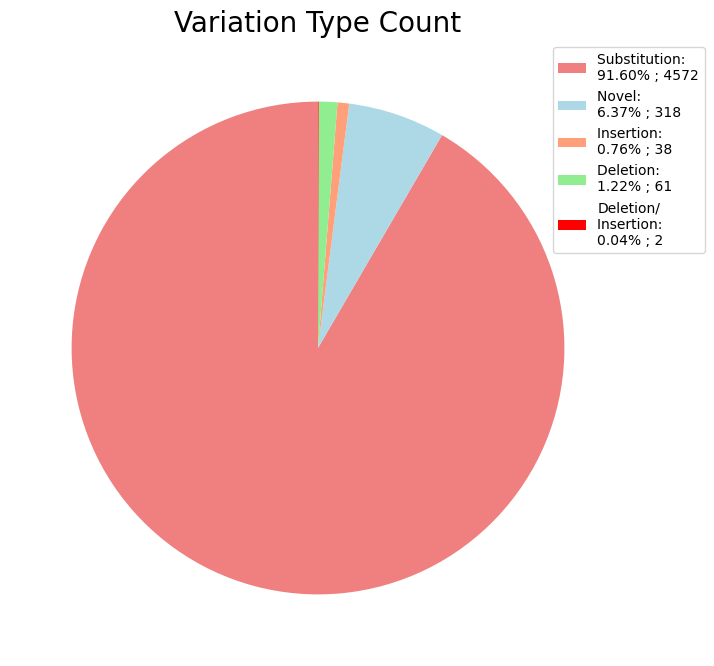

In [84]:
substitution_nums = len(variation_type_dict["substitution"])
novel_nums = len(variation_type_dict["novel"])
insertion_nums = len(variation_type_dict["insertion"])
deletion_nums = len(variation_type_dict["deletion"])
deletion_insertion_nums = len(variation_type_dict["deletion,insertion"])


all_variation_nums = substitution_nums + insertion_nums + deletion_nums + novel_nums + deletion_insertion_nums

sizes = [substitution_nums / all_variation_nums * 360, 
         novel_nums / all_variation_nums * 360,
         insertion_nums / all_variation_nums * 360, 
         deletion_nums / all_variation_nums * 360,
         deletion_insertion_nums / all_variation_nums * 360]
labels = ['Substitution: \n{} ; {}'.format("{:.2%}".format(substitution_nums / all_variation_nums), substitution_nums), 
          'Novel: \n{} ; {}'.format("{:.2%}".format(novel_nums / all_variation_nums), novel_nums),
          'Insertion: \n{} ; {}'.format("{:.2%}".format(insertion_nums / all_variation_nums), insertion_nums),  
          'Deletion: \n{} ; {}'.format("{:.2%}".format(deletion_nums / all_variation_nums), deletion_nums),
          'Deletion/\nInsertion: \n{} ; {}'.format("{:.2%}".format(deletion_insertion_nums / all_variation_nums),deletion_insertion_nums)]

colors = ['lightcoral', 'lightblue', 'lightsalmon', 'lightgreen', "red"]

plt.figure(figsize=(8, 8))

plt.pie(sizes, startangle=90, colors=colors)
 
plt.legend(labels, loc='upper left', bbox_to_anchor=(0.87, 1))

plt.title('Variation Type Count', fontsize=20)

plt.savefig('count-plots/variation_type_count-peps-plot.svg', format='svg')

In [63]:
def get_novel_usi(file, novel_set):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    df = df[df['sequence'].isin(novel_set)][['sequence','modifications','peptidoform','usi']]
    df.fillna("")
    return df 

In [64]:
all_novel_usi = pd.concat([get_novel_usi("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz", variation_type_dict["novel"]),
          get_novel_usi("PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz", variation_type_dict["novel"])], axis = 0)
all_novel_usi.to_csv("count-tables/novel_usi.tsv", header=1, sep="\t",index = None)

### Worst MS2PIP-SNR USI

In [65]:
def get_worst_SNR_usi(file, project):
    df = pd.read_table(file, sep = "," ,compression="gzip")
    df = df.sort_values(by='signal_to_noise', ascending=True)
    df = df.head(10)[['seq','modifications','usi','signal_to_noise']]
    df["Project"] = project
    df.fillna("")
    return df 

In [66]:
all_worst_SNR_usi = pd.concat([get_worst_SNR_usi("PXD010154/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip.csv.gz","PXD010154"),
          get_worst_SNR_usi("PXD016999/to-ms2pip-snr-tables/gca_peptides_for_deeplc_ms2pip.csv.gz","PXD016999")], axis = 0)
all_worst_SNR_usi.to_csv("count-tables/worst_SNR_usi.tsv", header=1, sep="\t",index = None)

###  variants PSM Number

In [80]:
variants = {"LLRDPADATEAHESSSR":"S>T",
            "LLRDPADASEAHESSSRGEAGAPGEEDIQGPTNADTEK":"K>N",
            "ERADEPQWSLYPSNSQVSEEVKTR":"D>N",
            "EDEEEEEGENYQKGEQGEDSSEEK":"R>Q(1)",
            "HLEEPGETQNAFLHER":"N>H",
            "EKSSQESGEEAGSQENHPQESKGQPR":"T>A",
            "GQPQSQEESEEGEEDATSEVDK":"R>Q(2)",
            "DHHSTHYRASEEEPEYGEEIKGYPGVQGPEDLEWERYR":"A>G",
            "MAHGYGEESEEERGLELGK":"P>L"}

In [118]:
def get_PSM_from_parquet(parquet_file1, parquet_file2, parquet_file3, vars):
    table1 = pq.read_table(parquet_file1, columns=["sequence"])
    from_parquet1 = table1.to_pandas()
    table2 = pq.read_table(parquet_file2, columns=["sequence"])
    from_parquet2 = table2.to_pandas()
    table3 = pq.read_table(parquet_file3, columns=["sequence"])
    from_parquet3 = table3.to_pandas()
    
    from_parquet = pd.concat([from_parquet1, from_parquet2, from_parquet3],axis = 0)
    # from_parquet  = from_parquet1

    total = 0
    for var in vars.keys():
        num = len(from_parquet[from_parquet["sequence"].apply(lambda x: x in var)])
        print("Number of {} : {}".format(var,num))
        total += num
    print("Number of total nums : {}".format(total))    
    print("Number of average nums : {}".format(int(total / len(vars))))

In [119]:
get_PSM_from_parquet("PXD010154/sdrf_parquet/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet", 
                     "PXD016999/sdrf_parquet/PXD016999-first-instrument-8b005cd8-d641-4d1e-a085-c92ed045b4da.psm.parquet",
                     "PXD016999/sdrf_parquet/PXD016999-second-instrument-2739df94-8ceb-4033-a8d3-91adba121f3f.psm.parquet",variants)

Number of LLRDPADATEAHESSSR : 152
Number of LLRDPADASEAHESSSRGEAGAPGEEDIQGPTNADTEK : 391
Number of ERADEPQWSLYPSNSQVSEEVKTR : 137
Number of EDEEEEEGENYQKGEQGEDSSEEK : 155
Number of HLEEPGETQNAFLHER : 79
Number of EKSSQESGEEAGSQENHPQESKGQPR : 723
Number of GQPQSQEESEEGEEDATSEVDK : 106
Number of DHHSTHYRASEEEPEYGEEIKGYPGVQGPEDLEWERYR : 296
Number of MAHGYGEESEEERGLELGK : 321
Number of total nums : 2360
Number of average nums : 262


In [100]:
def get_PSM_from_res(file1, file2, vars):
    table1 = pd.read_table(file1, sep = "," ,compression="gzip", usecols = ["sequence","peptidoform","reference_file_name","usi"])
    table2 = pd.read_table(file2, sep = "," ,compression="gzip", usecols = ["sequence","peptidoform","reference_file_name","usi"])
    table = pd.concat([table1,table2],axis = 0)
    # table = table1
    df_var_list = []
    for var in vars.keys():
        df_var = table[table["sequence"].apply(lambda x: x in var)]
        df_var['from_var_seq'] = var
        df_var_list.append(df_var)
    nine_df_var = pd.concat(df_var_list, ignore_index=True)
    return nine_df_var

In [101]:
CHGB_var_df = get_PSM_from_res("PXD010154/deeplc-tables/PXD010154_deeplc_filtered_95perc.csv.gz", 
                               "PXD016999/deeplc-tables/PXD016999_deeplc_filtered_95perc.csv.gz", variants).drop_duplicates()

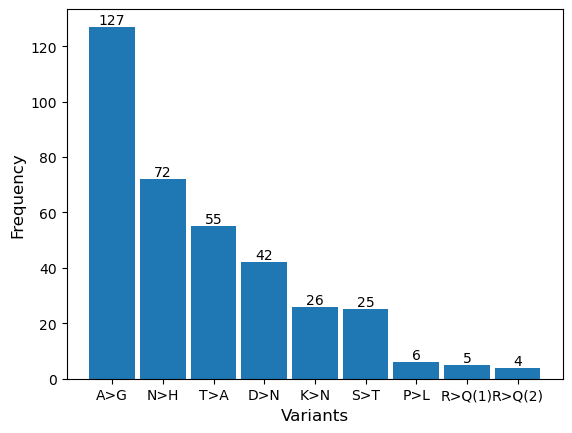

In [102]:
value_counts = CHGB_var_df["from_var_seq"].value_counts()

bar_width = 0.9

bars = plt.bar([variants[seq] for seq in value_counts.keys()], value_counts.values,width=bar_width)
plt.xlabel('Variants', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=0)
# plt.tight_layout()  
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.savefig('count-plots/CHGB_variants.svg', format='svg')
plt.show()

In [105]:
print("Number of final average nums: {}".format(int(sum(value_counts)/len(value_counts))))
value_counts

Number of final average nums: 40


DHHSTHYRASEEEPEYGEEIKGYPGVQGPEDLEWERYR    127
HLEEPGETQNAFLHER                           72
EKSSQESGEEAGSQENHPQESKGQPR                 55
ERADEPQWSLYPSNSQVSEEVKTR                   42
LLRDPADASEAHESSSRGEAGAPGEEDIQGPTNADTEK     26
LLRDPADATEAHESSSR                          25
MAHGYGEESEEERGLELGK                         6
EDEEEEEGENYQKGEQGEDSSEEK                    5
GQPQSQEESEEGEEDATSEVDK                      4
Name: from_var_seq, dtype: int64

In [108]:
# CHGB_var_df["tissue"] = CHGB_var_df["reference_file_name"].map(PXD010154_sdrf_info[0])
# CHGB_var_df["tissue"] = CHGB_var_df["reference_file_name"].map(PXD016999_sdrf_info[0])

CHGB_var_df["tissue"] = CHGB_var_df["reference_file_name"].apply(lambda x : PXD010154_sdrf_info[0][x] if PXD010154_sdrf_info[0].get(x) else PXD016999_sdrf_info[0][x])

# CHGB_var_df = CHGB_var_df.explode("tissue", ignore_index=True)
CHGB_var_df["tissue"] = CHGB_var_df["tissue"].apply(lambda x : ",".join(x))

In [109]:
CHGB_var_df

,reference_file_name,sequence,peptidoform,usi,from_var_seq,tissue
0,01226_C03_P012502_S00_N19_R1,DPADATEAHESSSR,DPADATEAHESSSR,mzspec:PXD010154:01226_C03_P012502_S00_N19_R1:...,LLRDPADATEAHESSSR,liver
1,01276_B03_P013128_S00_N17_R1,DPADATEAHESSSR,DPADATEAHESSSR,mzspec:PXD010154:01276_B03_P013128_S00_N17_R1:...,LLRDPADATEAHESSSR,stomach
2,01276_C03_P013128_S00_N18_R1,DPADATEAHESSSR,DPADATEAHESSSR,mzspec:PXD010154:01276_C03_P013128_S00_N18_R1:...,LLRDPADATEAHESSSR,stomach
3,01276_G02_P013128_S00_N14_R1,LLRDPADATEAHESSSR,LLRDPADATEAHESSSR,mzspec:PXD010154:01276_G02_P013128_S00_N14_R1:...,LLRDPADATEAHESSSR,stomach
4,01276_F02_P013128_S00_N13_R1,LLRDPADATEAHESSSR,LLRDPADATEAHESSSR,mzspec:PXD010154:01276_F02_P013128_S00_N13_R1:...,LLRDPADATEAHESSSR,stomach
...,...,...,...,...,...,...
357,Instrument1_sample19_S1R17_072916_Fr03,MAHGYGEESEEERGLELGK,[TMT6plex]-M[Oxidation]AHGYGEESEEERGLELGK[TMT6...,mzspec:PXD016999:Instrument1_sample19_S1R17_07...,MAHGYGEESEEERGLELGK,"tibial artery,Stomach,skeletal muscle tissue,p..."
358,Instrument1_sample24_S1R26_082616_Fr05,MAHGYGEESEEERGLELGK,[TMT6plex]-MAHGYGEESEEERGLELGK[TMT6plex],mzspec:PXD016999:Instrument1_sample24_S1R26_08...,MAHGYGEESEEERGLELGK,"heart left ventricle,skeletal muscle tissue,ao..."
359,SecondInstrument_Sample25_S2R10_042616_Fr05,MAHGYGEESEEERGLELGK,[TMT6plex]-MAHGYGEESEEERGLELGK[TMT6plex],mzspec:PXD016999:SecondInstrument_Sample25_S2R...,MAHGYGEESEEERGLELGK,"thyroid gland,heart atrial appendage,Small Int..."
360,SecondInstrument_Sample25_S2R10_042616_Fr04,MAHGYGEESEEERGLELGK,[TMT6plex]-M[Oxidation]AHGYGEESEEERGLELGK[TMT6...,mzspec:PXD016999:SecondInstrument_Sample25_S2R...,MAHGYGEESEEERGLELGK,"thyroid gland,heart atrial appendage,Small Int..."


In [110]:
CHGB_var_df.to_csv("count-tables/CHGB_var.tsv", header = 1,sep = "\t", index = None)

In [116]:
CHGB_var_df = CHGB_var_df[~CHGB_var_df["tissue"].str.contains(",")]

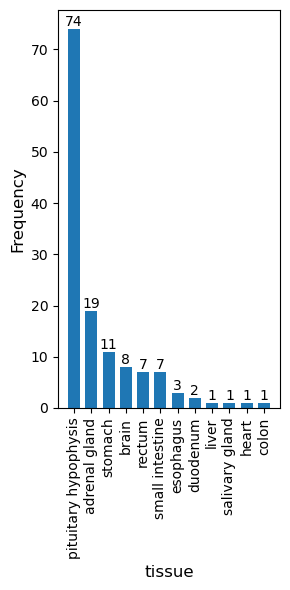

In [117]:
plt.figure(figsize=(3,6))
value_counts = CHGB_var_df["tissue"].value_counts()
bar_width = 0.7
bars = plt.bar(value_counts.index, value_counts.values,width=bar_width)
plt.xlabel('tissue', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=90)
plt.tight_layout()  
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.savefig('count-plots/CHGB_variants_tissue.svg', format='svg')
plt.show()